## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [81]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [82]:
# Opening JSON file 
f = open('complaints-2021-05-14_08_16.json')# Write the path to your data file and load it 
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [83]:
# Inspect the dataframe to understand the given data.
df.head()


,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [84]:
df.shape

(78313, 22)

In [85]:
#print the column names
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [86]:
#Assign new column names
df.rename(columns = {'_index': 'index', '_type': 'type', '_id': 'id', '_score': 'score', '_source.tags': 'tags', 
                    '_source.zip_code': 'zip_code', '_source.complaint_id': 'complaint_id', '_source.issue': 'issue', 
                    '_source.date_received': 'date_received', '_source.state': 'state', '_source.consumer_disputed': 
                    'consumer_disputed', '_source.product': 'product', '_source.company_response': 'company_response', 
                    '_source.company': 'company', '_source.submitted_via': 'submitted_via', '_source.date_sent_to_company': 
                    'date_sent_to_company', '_source.company_public_response': 'company_public_response', '_source.sub_product': 'sub_product', 
                    '_source.timely': 'timely', '_source.complaint_what_happened': 'complaint_what_happened', 
                    '_source.sub_issue': 'sub_issue', '_source.consumer_consent_provided': 'consumer_consent_provided'}, 
                    inplace=True)

In [87]:
df.columns

Index(['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id',
       'issue', 'date_received', 'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via', 'date_sent_to_company',
       'company_public_response', 'sub_product', 'timely',
       'complaint_what_happened', 'sub_issue', 'consumer_consent_provided'],
      dtype='object')

In [88]:
df.rename(columns = {'complaint_what_happened': 'complaints'}, inplace=True)

In [89]:
#Assign nan in place of blanks in the complaints column
df['complaints'].replace('', np.nan, inplace=True)

In [90]:
df.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaints,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,NaN,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,NaN,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,NaN,Charged too much interest,N/A


In [91]:
df['complaints'].isna().sum()

57241

In [92]:
df.shape

(78313, 22)

In [93]:
#Remove all rows where complaints column is nan
df = df[df['complaints'].notna()]

In [94]:
df.shape

(21072, 22)

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Use POS tags to get relevant words from the texts.


In [95]:
df['lemmatized_complaints'] = df['complaints']

In [96]:
df.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaints,sub_issue,consumer_consent_provided,lemmatized_complaints
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided,Good morning my name is XXXX XXXX and I apprec...
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided,I upgraded my XXXX XXXX card in XX/XX/2018 and...
10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,...,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,Chase Card was reported on XX/XX/2019. However...,Information belongs to someone else,Consent provided,Chase Card was reported on XX/XX/2019. However...
11,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,...,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,"On XX/XX/2018, while trying to book a XXXX XX...",Information belongs to someone else,Consent provided,"On XX/XX/2018, while trying to book a XXXX XX..."
14,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,...,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for {$1600.00} i de...,Funds not handled or disbursed as instructed,Consent provided,my grand son give me check for {$1600.00} i de...


In [97]:
# Write your function here to clean the text and remove all the unnecessary elements.
from nltk.tokenize import word_tokenize
import string
import re

def clean_text(text):
    # convert to lower case
    #text = text.lower()
    # split into words
    tokens = word_tokenize(text)
    # convert to lower case
    tokens = [w.lower() for w in tokens]
    #remove text in square brackets
    tokens2 = [re.sub("[\[].*?[\]]", "", w) for w in tokens]
    # remove punctuation from each word
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens2]
    # remove remaining tokens that are not alphabetic
    text = [word for word in stripped if word.isalpha()]
    return " ".join(text)

In [98]:
df['lemmatized_complaints'] = pd.DataFrame(df['lemmatized_complaints'].apply(lambda x: clean_text(x)))

In [99]:
df.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaints,sub_issue,consumer_consent_provided,lemmatized_complaints
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided,good morning my name is xxxx xxxx and i apprec...
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided,i upgraded my xxxx xxxx card in and was told b...
10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,...,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,Chase Card was reported on XX/XX/2019. However...,Information belongs to someone else,Consent provided,chase card was reported on however fraudulent ...
11,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,...,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,"On XX/XX/2018, while trying to book a XXXX XX...",Information belongs to someone else,Consent provided,on while trying to book a xxxx xxxx ticket i c...
14,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,...,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for {$1600.00} i de...,Funds not handled or disbursed as instructed,Consent provided,my grand son give me check for i deposit it in...


In [100]:
#Write your function to Lemmatize the texts

from nltk.stem import WordNetLemmatizer # we can also use lemmatizer instead of stemming
wordnet_lemmatizer = WordNetLemmatizer()
from nltk.corpus import stopwords
nltk.download('wordnet')

#Function to Lemmatize the texts
def lemmatizer(text):
    # tokenise text
    tokens = word_tokenize(text)
    sent = [wordnet_lemmatizer.lemmatize(word) for word in tokens if not word in set(stopwords.words('english'))]
    return " ".join(sent)

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/malleswarisubbu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [101]:
df['lemmatized_complaints'] = pd.DataFrame(df['lemmatized_complaints'].apply(lambda x: lemmatizer(x)))

In [102]:
df.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaints,sub_issue,consumer_consent_provided,lemmatized_complaints
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided,good morning name xxxx xxxx appreciate could h...
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided,upgraded xxxx xxxx card told agent upgrade ann...
10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,...,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,Chase Card was reported on XX/XX/2019. However...,Information belongs to someone else,Consent provided,chase card reported however fraudulent applica...
11,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,...,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,"On XX/XX/2018, while trying to book a XXXX XX...",Information belongs to someone else,Consent provided,trying book xxxx xxxx ticket came across offer...
14,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,...,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for {$1600.00} i de...,Funds not handled or disbursed as instructed,Consent provided,grand son give check deposit chase account fun...


In [103]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean = df[['complaints', 'lemmatized_complaints']]

In [104]:
df_clean

,complaints,lemmatized_complaints
1,Good morning my name is XXXX XXXX and I apprec...,good morning name xxxx xxxx appreciate could h...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,upgraded xxxx xxxx card told agent upgrade ann...
10,Chase Card was reported on XX/XX/2019. However...,chase card reported however fraudulent applica...
11,"On XX/XX/2018, while trying to book a XXXX XX...",trying book xxxx xxxx ticket came across offer...
14,my grand son give me check for {$1600.00} i de...,grand son give check deposit chase account fun...
...,...,...
78303,After being a Chase Card customer for well ove...,chase card customer well decade offered multip...
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",wednesday xxxxxxxx called chas xxxx xxxx visa ...
78310,I am not familiar with XXXX pay and did not un...,familiar xxxx pay understand great risk provid...
78311,I have had flawless credit for 30 yrs. I've ha...,flawless credit yr chase credit card chase fre...


In [105]:
#Write your function to extract the POS tags
nlp=spacy.load('en_core_web_sm',disable=['parser','ner'])

def extract_nn_tag_text(text):
    doc = nlp(text)
    nouns = []
    for tok in doc:
        if (tok.tag_=="NN"):
            nouns.append(tok.text)
    return " ".join(nouns)

In [106]:
df_clean['complaint_POS_removed'] = pd.DataFrame(df_clean['lemmatized_complaints'].apply(lambda x: extract_nn_tag_text(x)))

<ipython-input-106-c889450009df>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [107]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,complaints,lemmatized_complaints,complaint_POS_removed
1,Good morning my name is XXXX XXXX and I apprec...,good morning name xxxx xxxx appreciate could h...,morning name xxxx xxxx appreciate chase bank c...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,upgraded xxxx xxxx card told agent upgrade ann...,xxxx card agent anniversary date agent informa...
10,Chase Card was reported on XX/XX/2019. However...,chase card reported however fraudulent applica...,chase card application identity consent servic...
11,"On XX/XX/2018, while trying to book a XXXX XX...",trying book xxxx xxxx ticket came across offer...,book xxxx xxxx ticket offer ticket reward card...
14,my grand son give me check for {$1600.00} i de...,grand son give check deposit chase account fun...,son check deposit chase account fund chase ban...
...,...,...,...
78303,After being a Chase Card customer for well ove...,chase card customer well decade offered multip...,chase card customer decade solicitation credit...
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",wednesday xxxxxxxx called chas xxxx xxxx visa ...,xxxxxxxx xxxx xxxx visa credit card provider c...
78310,I am not familiar with XXXX pay and did not un...,familiar xxxx pay understand great risk provid...,xxxx pay risk consumer chase bank app chase ye...
78311,I have had flawless credit for 30 yrs. I've ha...,flawless credit yr chase credit card chase fre...,credit yr chase credit card chase freedom xxxx...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




(array([1.0013e+04, 6.2230e+03, 2.4300e+03, 1.2330e+03, 5.5000e+02,
        2.5600e+02, 9.9000e+01, 7.7000e+01, 5.0000e+01, 3.0000e+01,
        1.9000e+01, 1.8000e+01, 2.0000e+01, 1.2000e+01, 3.0000e+00,
        6.0000e+00, 6.0000e+00, 5.0000e+00, 1.0000e+00, 3.0000e+00,
        2.0000e+00, 1.0000e+00, 2.0000e+00, 1.0000e+00, 2.0000e+00,
        0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([    0. ,   305.8,   611.6,   917.4,  1223.2,  1529. ,  1834.8,
         2140.6,  2446.4,  2752.2,  3058. ,  3363.8,  3669.6,  3975.4,
         4281.2,  4587. ,  4892.8,  5198.6,  5504.4,  5810.2,  6116. ,
         6421.8,  6727.6,  7033.4,  7339.2,  7645. ,  7950.8,  8256.6,
         8562.4,  8868.2,  9174. ,

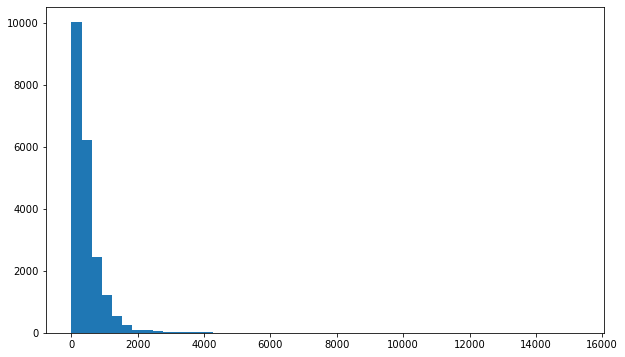

In [108]:
# Write your code here to visualise the data according to the 'Complaint' character length
plt.figure(figsize=(10,6))
doc_lens = [len(d) for d in df_clean['complaint_POS_removed']]
plt.hist(doc_lens, bins = 50)

#### Find the top 40 words by frequency among all the articles after processing the text.

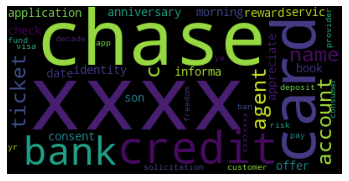

In [109]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
#!pip install wordcloud
from wordcloud import WordCloud
stoplist = set(stopwords.words("english"))


wordcloud = WordCloud(stopwords=stoplist,max_words=40).generate(str(df_clean['complaint_POS_removed']))

print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show();

In [110]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

<ipython-input-110-2ee47e6ecbae>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [111]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_top_n_unigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(1, 1), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    #print(bag_of_words)
    sum_words = bag_of_words.sum(axis=0) 
    print("--1",sum_words)
    for word, idx in vec.vocabulary_.items():
        print(word)
        print(idx)
        break
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    #print("-31",words_freq)
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_unigram_words = get_top_n_unigram(df_clean['Complaint_clean'], 30)

--1 [[ 6  1  1 ... 32  1  1]]
morning
9184


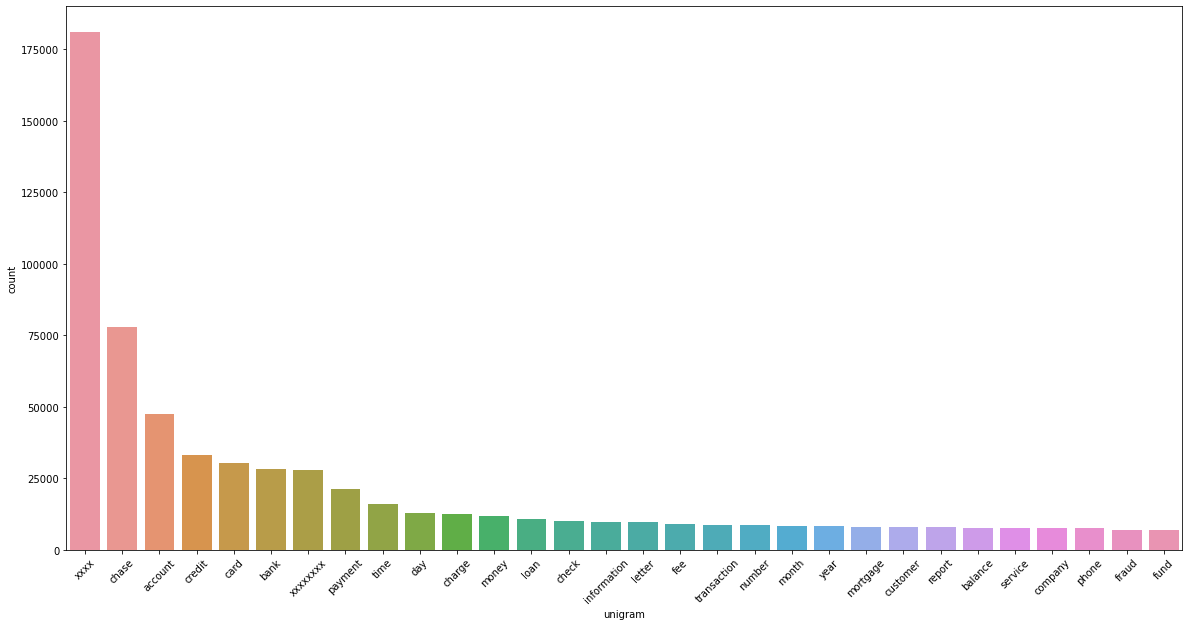

In [112]:
df3_unigram = pd.DataFrame(common_unigram_words, columns = ['unigram' , 'count'])
plt.figure(figsize=(20,10))
fig = sns.barplot(x=df3_unigram['unigram'], y=df3_unigram['count'])
plt.xticks(rotation=45)
plt.show()

In [113]:
#Print the top 10 words in the unigram frequency
df3_unigram.head(10)

,unigram,count
0,xxxx,180955
1,chase,78077
2,account,47360
3,credit,33050
4,card,30469
5,bank,28207
6,xxxxxxxx,27919
7,payment,21173
8,time,16028
9,day,12961


In [114]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    #print(bag_of_words)
    sum_words = bag_of_words.sum(axis=0) 
    print("--1",sum_words)
    for word, idx in vec.vocabulary_.items():
        print(word)
        print(idx)
        break
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    #print("-31",words_freq)
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [115]:
common_words_bigram = get_top_n_bigram(df_clean['Complaint_clean'], 30)

--1 [[1 1 2 ... 1 1 1]]
morning xxxx
164746


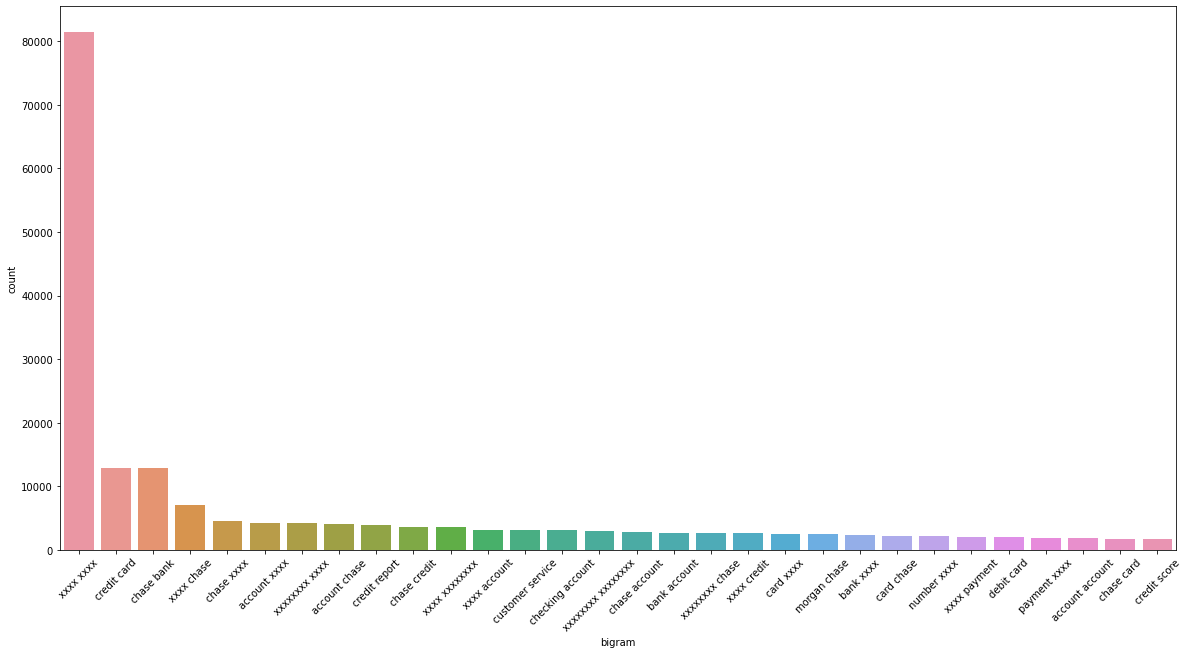

In [116]:

df3_bigram = pd.DataFrame(common_words_bigram, columns = ['bigram' , 'count'])
plt.figure(figsize=(20,10))
fig = sns.barplot(x=df3_bigram['bigram'], y=df3_bigram['count'])
plt.xticks(rotation=45)
plt.show()

In [117]:
#Print the top 10 words in the bigram frequency
df3_bigram.head(10)

,bigram,count
0,xxxx xxxx,81408
1,credit card,12860
2,chase bank,12833
3,xxxx chase,7046
4,chase xxxx,4568
5,account xxxx,4329
6,xxxxxxxx xxxx,4217
7,account chase,4147
8,credit report,3877
9,chase credit,3589


In [118]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    #print(bag_of_words)
    sum_words = bag_of_words.sum(axis=0) 
    print("--1",sum_words)
    for word, idx in vec.vocabulary_.items():
        print(word)
        print(idx)
        break
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    #print("-31",words_freq)
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_trigram_words = get_top_n_trigram(df_clean['Complaint_clean'], 30)

--1 [[1 1 2 ... 1 1 1]]
morning xxxx xxxx
459670


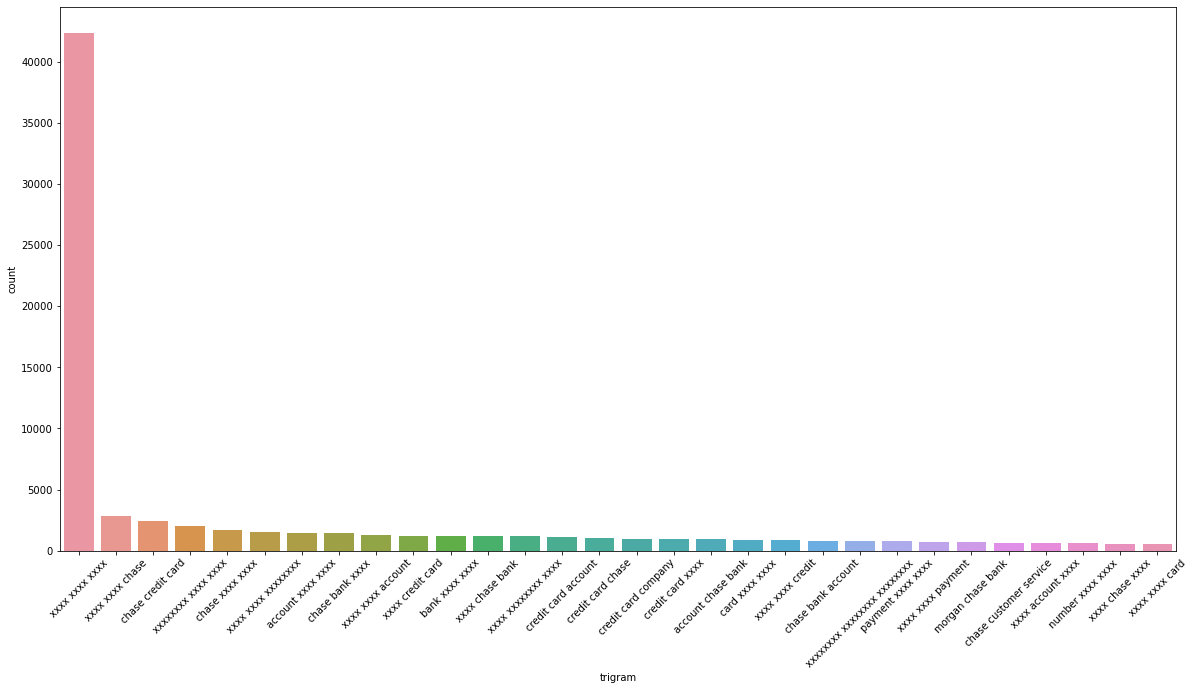

In [119]:
df3_trigram = pd.DataFrame(common_trigram_words, columns = ['trigram' , 'count'])
plt.figure(figsize=(20,10))
fig = sns.barplot(x=df3_trigram['trigram'], y=df3_trigram['count'])
plt.xticks(rotation=45)
plt.show()

In [120]:
#Print the top 10 words in the trigram frequency
df3_trigram.head(10)

,trigram,count
0,xxxx xxxx xxxx,42367
1,xxxx xxxx chase,2836
2,chase credit card,2456
3,xxxxxxxx xxxx xxxx,2004
4,chase xxxx xxxx,1709
5,xxxx xxxx xxxxxxxx,1558
6,account xxxx xxxx,1471
7,chase bank xxxx,1444
8,xxxx xxxx account,1247
9,xxxx credit card,1221


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [121]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

<ipython-input-121-d4beb8194a2f>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [122]:
#All masked texts has been removed
df_clean

,complaints,lemmatized_complaints,complaint_POS_removed,Complaint_clean
1,Good morning my name is XXXX XXXX and I apprec...,good morning name xxxx xxxx appreciate could h...,morning name xxxx xxxx appreciate chase bank c...,morning name appreciate chase bank cardmembe...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,upgraded xxxx xxxx card told agent upgrade ann...,xxxx card agent anniversary date agent informa...,card agent anniversary date agent information...
10,Chase Card was reported on XX/XX/2019. However...,chase card reported however fraudulent applica...,chase card application identity consent servic...,chase card application identity consent servic...
11,"On XX/XX/2018, while trying to book a XXXX XX...",trying book xxxx xxxx ticket came across offer...,book xxxx xxxx ticket offer ticket reward card...,book ticket offer ticket reward card informa...
14,my grand son give me check for {$1600.00} i de...,grand son give check deposit chase account fun...,son check deposit chase account fund chase ban...,son check deposit chase account fund chase ban...
...,...,...,...,...
78303,After being a Chase Card customer for well ove...,chase card customer well decade offered multip...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",wednesday xxxxxxxx called chas xxxx xxxx visa ...,xxxxxxxx xxxx xxxx visa credit card provider c...,visa credit card provider claim purchase pr...
78310,I am not familiar with XXXX pay and did not un...,familiar xxxx pay understand great risk provid...,xxxx pay risk consumer chase bank app chase ye...,pay risk consumer chase bank app chase year t...
78311,I have had flawless credit for 30 yrs. I've ha...,flawless credit yr chase credit card chase fre...,credit yr chase credit card chase freedom xxxx...,credit yr chase credit card chase freedom pro...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [123]:
#Write your code here to initialise the TfidfVectorizer 
vectorizer = TfidfVectorizer(stop_words='english',max_df=0.95, min_df=2)

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [124]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
tfidf_vectors = vectorizer.fit_transform(df_clean['Complaint_clean'])

In [125]:
tfidf_vectors.A

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [126]:
vectorizer.get_feature_names()

['aa',
 'aarp',
 'aba',
 'abandonment',
 'abatement',
 'abbreviation',
 'abd',
 'aberrant',
 'abet',
 'abhorrent',
 'abide',
 'ability',
 'abou',
 'absence',
 'absent',
 'absolve',
 'absorb',
 'absurdity',
 'abundance',
 'abuse',
 'abuser',
 'abusive',
 'ac',
 'acc',
 'acccount',
 'accelerate',
 'acceleration',
 'accent',
 'accept',
 'acceptance',
 'access',
 'accessibility',
 'accessing',
 'accessory',
 'accident',
 'acco',
 'accommodate',
 'accommodation',
 'accompany',
 'accomplice',
 'accomplish',
 'accord',
 'accordance',
 'accou',
 'accouint',
 'accoun',
 'account',
 'accountability',
 'accountand',
 'accountant',
 'accountbalance',
 'accountchase',
 'accountholder',
 'accounti',
 'accounting',
 'accountit',
 'accountlevel',
 'accounton',
 'accountplease',
 'accountschasecom',
 'accountshe',
 'accountyou',
 'accout',
 'accrue',
 'accrueing',
 'acct',
 'accumulate',
 'accumulation',
 'accunt',
 'accuracy',
 'accurateness',
 'accusation',
 'accuse',
 'accusing',
 'ach',
 'acion',
 

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [127]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [128]:
from sklearn import decomposition
#Load your nmf_model with the n_components i.e 5
num_topics = 5#write the value you want to test out

#keep the random_state =40
nmf_model = decomposition.NMF(n_components=num_topics, random_state=40)#write your code here

In [129]:
#nmf_model.fit(dtm)
W = nmf_model.fit_transform(tfidf_vectors)
len(vectorizer.get_feature_names())

7245

In [130]:
print(W)

[[0.02444975 0.00807633 0.02420218 0.01247843 0.00612237]
 [0.00748966 0.0152539  0.00137767 0.00280175 0.00234298]
 [0.         0.02432044 0.00214887 0.0270517  0.        ]
 ...
 [0.01671051 0.0146572  0.01151157 0.01824964 0.        ]
 [0.         0.06248221 0.         0.00461237 0.08965066]
 [0.03303394 0.00559709 0.00779026 0.03514224 0.08920886]]


In [131]:
H = nmf_model.components_
H

array([[0.00000000e+00, 0.00000000e+00, 1.17730963e-03, ...,
        2.04777680e-03, 5.86509521e-06, 1.33186953e-03],
       [4.88899556e-04, 1.78791230e-02, 0.00000000e+00, ...,
        6.02448374e-03, 0.00000000e+00, 1.60780286e-03],
       [4.38633838e-04, 1.61703711e-04, 0.00000000e+00, ...,
        3.01844478e-03, 2.35973475e-03, 3.33232108e-03],
       [1.89834380e-05, 1.70244735e-03, 0.00000000e+00, ...,
        2.45868464e-03, 1.16413777e-03, 0.00000000e+00],
       [1.91665766e-04, 0.00000000e+00, 0.00000000e+00, ...,
        4.54472419e-03, 0.00000000e+00, 2.80297732e-03]])

In [132]:
#Print the Top15 words for each of the topics
num_words=15

vocab = np.array(vectorizer.get_feature_names())

top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_words-1:-1]]
topic_words = ([top_words(t) for t in H])
topics = [' '.join(t) for t in topic_words]
topics

['account bank chase check money fund deposit checking branch day transaction number claim business transfer',
 'card charge chase credit dispute purchase transaction fraud service fee merchant time balance company customer',
 'loan mortgage chase home modification property year letter rate bank time document foreclosure house sale',
 'credit report inquiry card account score bureau reporting debt company information chase identity application limit',
 'payment balance fee month statement day pay date time auto credit chase account year error']

In [133]:
vocab

array(['aa', 'aarp', 'aba', ..., 'zip', 'zombie', 'zone'], dtype='<U96')

In [134]:
topic_words_to_display = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic{i + 1}' for i in range(num_topics)],
                           columns=[f'Word{i + 1}' for i in range(15)]).astype(str)
for i in range(num_topics):
    ix = H[i].argsort()[::-1][:15]
    topic_words_to_display.iloc[i] = vocab[ix]

topic_words_to_display

,Word1,Word2,Word3,Word4,Word5,Word6,Word7,Word8,Word9,Word10,Word11,Word12,Word13,Word14,Word15
Topic1,account,bank,chase,check,money,fund,deposit,checking,branch,day,transaction,number,claim,business,transfer
Topic2,card,charge,chase,credit,dispute,purchase,transaction,fraud,service,fee,merchant,time,balance,company,customer
Topic3,loan,mortgage,chase,home,modification,property,year,letter,rate,bank,time,document,foreclosure,house,sale
Topic4,credit,report,inquiry,card,account,score,bureau,reporting,debt,company,information,chase,identity,application,limit
Topic5,payment,balance,fee,month,statement,day,pay,date,time,auto,credit,chase,account,year,error


In [135]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
colnames = ["Topic" + str(i) for i in range(nmf_model.n_components)]
docnames = ["Doc" + str(i) for i in range(len(df_clean['Complaint_clean']))]
df_doc_topic = pd.DataFrame(np.round(W, 2), columns=colnames, index=docnames)
significant_topic = np.argmax(df_doc_topic.values, axis=1)
df_doc_topic['dominant_topic'] = significant_topic
df_clean['topic_tar'] = significant_topic

<ipython-input-135-731b6385ae1a>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [136]:
df_doc_topic

,Topic0,Topic1,Topic2,Topic3,Topic4,dominant_topic
Doc0,0.02,0.01,0.02,0.01,0.01,0
Doc1,0.01,0.02,0.00,0.00,0.00,1
Doc2,0.00,0.02,0.00,0.03,0.00,3
Doc3,0.02,0.02,0.02,0.05,0.00,3
Doc4,0.07,0.00,0.01,0.00,0.00,0
...,...,...,...,...,...,...
Doc21067,0.00,0.08,0.00,0.03,0.02,1
Doc21068,0.01,0.03,0.01,0.00,0.00,1
Doc21069,0.02,0.01,0.01,0.02,0.00,0
Doc21070,0.00,0.06,0.00,0.00,0.09,4


In [137]:
df_clean.head()

,complaints,lemmatized_complaints,complaint_POS_removed,Complaint_clean,topic_tar
1,Good morning my name is XXXX XXXX and I apprec...,good morning name xxxx xxxx appreciate could h...,morning name xxxx xxxx appreciate chase bank c...,morning name appreciate chase bank cardmembe...,0
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,upgraded xxxx xxxx card told agent upgrade ann...,xxxx card agent anniversary date agent informa...,card agent anniversary date agent information...,1
10,Chase Card was reported on XX/XX/2019. However...,chase card reported however fraudulent applica...,chase card application identity consent servic...,chase card application identity consent servic...,3
11,"On XX/XX/2018, while trying to book a XXXX XX...",trying book xxxx xxxx ticket came across offer...,book xxxx xxxx ticket offer ticket reward card...,book ticket offer ticket reward card informa...,3
14,my grand son give me check for {$1600.00} i de...,grand son give check deposit chase account fun...,son check deposit chase account fund chase ban...,son check deposit chase account fund chase ban...,0


In [138]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = df_clean['topic_tar'].apply(lambda x: "Topic "+str(x))#write your code to assign topics to each rows.

<ipython-input-138-795d43eab1af>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [139]:
df_clean.head()

,complaints,lemmatized_complaints,complaint_POS_removed,Complaint_clean,topic_tar,Topic
1,Good morning my name is XXXX XXXX and I apprec...,good morning name xxxx xxxx appreciate could h...,morning name xxxx xxxx appreciate chase bank c...,morning name appreciate chase bank cardmembe...,0,Topic 0
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,upgraded xxxx xxxx card told agent upgrade ann...,xxxx card agent anniversary date agent informa...,card agent anniversary date agent information...,1,Topic 1
10,Chase Card was reported on XX/XX/2019. However...,chase card reported however fraudulent applica...,chase card application identity consent servic...,chase card application identity consent servic...,3,Topic 3
11,"On XX/XX/2018, while trying to book a XXXX XX...",trying book xxxx xxxx ticket came across offer...,book xxxx xxxx ticket offer ticket reward card...,book ticket offer ticket reward card informa...,3,Topic 3
14,my grand son give me check for {$1600.00} i de...,grand son give check deposit chase account fun...,son check deposit chase account fund chase ban...,son check deposit chase account fund chase ban...,0,Topic 0


In [140]:
#Print the first 5 Complaint for each of the Topics
df_clean=df_clean.groupby('Topic').head(5)
df_clean.sort_values('Topic')

,complaints,lemmatized_complaints,complaint_POS_removed,Complaint_clean,topic_tar,Topic
1,Good morning my name is XXXX XXXX and I apprec...,good morning name xxxx xxxx appreciate could h...,morning name xxxx xxxx appreciate chase bank c...,morning name appreciate chase bank cardmembe...,0,Topic 0
14,my grand son give me check for {$1600.00} i de...,grand son give check deposit chase account fun...,son check deposit chase account fund chase ban...,son check deposit chase account fund chase ban...,0,Topic 0
24,mishandling of this account by Chase auto and ...,mishandling account chase auto xxxx,account chase auto xxxx,account chase auto,0,Topic 0
17,With out notice J.P. Morgan Chase restricted m...,notice jp morgan chase restricted account debi...,morgan chase account debit card tuesday thursd...,morgan chase account debit card tuesday thursd...,0,Topic 0
21,"On XXXX XX/XX/2019, I made a {$300.00} payment...",xxxx made payment online retailer using chase ...,xxxx payment retailer chase pay xxxx chase web...,payment retailer chase pay chase website sca...,0,Topic 0
50,I AM A SENIOR CITIZEN THAT HAS BEEN SCAMMED BY...,senior citizen scammed several company xxxx xx...,citizen company xxxx xxxx time share company n...,citizen company time share company nothing r...,1,Topic 1
45,I made a purchase with XXXX XXXX XXXX on XX/XX...,made purchase xxxx xxxx xxxx amount charged tw...,purchase xxxx xxxx xxxx amount transaction dis...,purchase amount transaction dispute case ch...,1,Topic 1
40,"XXXX XXXX a sofa, love seat, table and chairs ...",xxxx xxxx sofa love seat table chair never del...,xxxx xxxx sofa love seat table chair debit car...,sofa love seat table chair debit card bank v...,1,Topic 1
32,My chase amazon card was declined for a cateri...,chase amazon card declined catering order plac...,chase amazon card catering order brother funer...,chase amazon card catering order brother funer...,1,Topic 1
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,upgraded xxxx xxxx card told agent upgrade ann...,xxxx card agent anniversary date agent informa...,card agent anniversary date agent information...,1,Topic 1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [141]:
#Create the dictionary of Topic names and Topics

Topic_names = {
    'Topic 0': 'Bank Account services',
    'Topic 1': 'Theft/Dispute Reporting',
    'Topic 2': 'Mortgage/Loan',
    'Topic 3': 'Credit card or prepaid card',
    'Topic 4': 'Others'
}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

<ipython-input-141-cd6dc6146394>:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [142]:
df_clean

,complaints,lemmatized_complaints,complaint_POS_removed,Complaint_clean,topic_tar,Topic
1,Good morning my name is XXXX XXXX and I apprec...,good morning name xxxx xxxx appreciate could h...,morning name xxxx xxxx appreciate chase bank c...,morning name appreciate chase bank cardmembe...,0,Bank Account services
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,upgraded xxxx xxxx card told agent upgrade ann...,xxxx card agent anniversary date agent informa...,card agent anniversary date agent information...,1,Theft/Dispute Reporting
10,Chase Card was reported on XX/XX/2019. However...,chase card reported however fraudulent applica...,chase card application identity consent servic...,chase card application identity consent servic...,3,Credit card or prepaid card
11,"On XX/XX/2018, while trying to book a XXXX XX...",trying book xxxx xxxx ticket came across offer...,book xxxx xxxx ticket offer ticket reward card...,book ticket offer ticket reward card informa...,3,Credit card or prepaid card
14,my grand son give me check for {$1600.00} i de...,grand son give check deposit chase account fun...,son check deposit chase account fund chase ban...,son check deposit chase account fund chase ban...,0,Bank Account services
15,Can you please remove inquiry,please remove inquiry,inquiry,inquiry,3,Credit card or prepaid card
17,With out notice J.P. Morgan Chase restricted m...,notice jp morgan chase restricted account debi...,morgan chase account debit card tuesday thursd...,morgan chase account debit card tuesday thursd...,0,Bank Account services
20,"During the summer months, I experience a decli...",summer month experience decline income due emp...,summer month experience decline income employm...,summer month experience decline income employm...,4,Others
21,"On XXXX XX/XX/2019, I made a {$300.00} payment...",xxxx made payment online retailer using chase ...,xxxx payment retailer chase pay xxxx chase web...,payment retailer chase pay chase website sca...,0,Bank Account services
23,I have a Chase credit card which is incorrectl...,chase credit card incorrectly reporting data c...,chase credit card credit report company issue,chase credit card credit report company issue,3,Credit card or prepaid card


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [143]:
#Create the dictionary again of Topic names and Topics

Topic_names = {
    'Bank Account services': '0',
    'Theft/Dispute Reporting': '1',
    'Mortgage/Loan': '2',
    'Credit card or prepaid card': '3',
    'Others': '4'
}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

<ipython-input-143-3d64256ad228>:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [144]:
df_clean

,complaints,lemmatized_complaints,complaint_POS_removed,Complaint_clean,topic_tar,Topic
1,Good morning my name is XXXX XXXX and I apprec...,good morning name xxxx xxxx appreciate could h...,morning name xxxx xxxx appreciate chase bank c...,morning name appreciate chase bank cardmembe...,0,0
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,upgraded xxxx xxxx card told agent upgrade ann...,xxxx card agent anniversary date agent informa...,card agent anniversary date agent information...,1,1
10,Chase Card was reported on XX/XX/2019. However...,chase card reported however fraudulent applica...,chase card application identity consent servic...,chase card application identity consent servic...,3,3
11,"On XX/XX/2018, while trying to book a XXXX XX...",trying book xxxx xxxx ticket came across offer...,book xxxx xxxx ticket offer ticket reward card...,book ticket offer ticket reward card informa...,3,3
14,my grand son give me check for {$1600.00} i de...,grand son give check deposit chase account fun...,son check deposit chase account fund chase ban...,son check deposit chase account fund chase ban...,0,0
15,Can you please remove inquiry,please remove inquiry,inquiry,inquiry,3,3
17,With out notice J.P. Morgan Chase restricted m...,notice jp morgan chase restricted account debi...,morgan chase account debit card tuesday thursd...,morgan chase account debit card tuesday thursd...,0,0
20,"During the summer months, I experience a decli...",summer month experience decline income due emp...,summer month experience decline income employm...,summer month experience decline income employm...,4,4
21,"On XXXX XX/XX/2019, I made a {$300.00} payment...",xxxx made payment online retailer using chase ...,xxxx payment retailer chase pay xxxx chase web...,payment retailer chase pay chase website sca...,0,0
23,I have a Chase credit card which is incorrectl...,chase credit card incorrectly reporting data c...,chase credit card credit report company issue,chase credit card credit report company issue,3,3


In [145]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=df_clean[['complaints', 'Topic']]

In [146]:
training_data

,complaints,Topic
1,Good morning my name is XXXX XXXX and I apprec...,0
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,1
10,Chase Card was reported on XX/XX/2019. However...,3
11,"On XX/XX/2018, while trying to book a XXXX XX...",3
14,my grand son give me check for {$1600.00} i de...,0
15,Can you please remove inquiry,3
17,With out notice J.P. Morgan Chase restricted m...,0
20,"During the summer months, I experience a decli...",4
21,"On XXXX XX/XX/2019, I made a {$300.00} payment...",0
23,I have a Chase credit card which is incorrectl...,3


####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [147]:
import pickle
from sklearn.feature_extraction.text import TfidfTransformer
#Write your code to get the Vector count
count_vect = CountVectorizer()

#Write your code here to transform the word vector to tf-idf
X = count_vect.fit_transform(training_data['complaints'])
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X)

#SAVE TF-IDF
pickle.dump(tfidf_transformer, open("tfidf.pkl","wb"))
y= training_data['Topic']

In [148]:
#Create the train & test data using the train_test_split on the tf-idf & topics
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, y, test_size=0.25, random_state=42)

You have to try atleast 2 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

## Model 1: Multinomial Naive Bayes Model

In [149]:
# Write your code here to build any 3 models and evaluate them using the required metrics

# Multinomial Naive Bayes

from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB().fit(X_train, y_train)

#SAVE MODEL
pickle.dump(clf, open("nb_model.pkl", "wb"))

In [150]:
predicted_naive_bayes = clf.predict(X_test)
result_bayes = pd.DataFrame( {'true_labels': y_test,'predicted_labels': predicted_naive_bayes})

for predicted_item, result in zip(predicted_naive_bayes, y_test):
    #print(target_names[predicted_item], ' - ', y_test)
    print(predicted_item, result)    

1 0
1 2
2 0
1 4
1 3
1 3
1 1


In [151]:
result_bayes

,true_labels,predicted_labels
21,0,1
57,2,1
1,0,2
141,4,1
26,3,1
23,3,1
40,1,1


## Evaluating Multinomial Naive Bayes Model

In [152]:
# printing the overall accuracy
from sklearn import metrics
accuracy_naive_bayes = metrics.accuracy_score(y_test, predicted_naive_bayes)
print("accuracy:   %0.3f" % accuracy_naive_bayes)

accuracy:   0.143


# Model 2: Logistic Regression

In [153]:
#imports
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

#instantiate a logistic regression model
lr = LogisticRegression(random_state=40)

#train the model using X_train
lr.fit(X_train, y_train)

#make class predictions for X_test
predicted_logisticreg = lr.predict(X_test)
result_logisticreg = pd.DataFrame( {'true_labels': y_test,'predicted_labels': predicted_logisticreg})

for predicted_item, result in zip(predicted_logisticreg, y_test):
    print(predicted_item, result)

#calculate accuracy
accuracy_logisticreg = metrics.accuracy_score(y_test, predicted_logisticreg)
print("accuracy:   %0.3f" % accuracy_logisticreg)

1 0
2 2
2 0
1 4
1 3
1 3
2 1
accuracy:   0.143


# Model 3: Decision Tree

In [154]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier(max_depth=4, random_state=40)
dtc.fit(X_train, y_train)

predicted_dtree = dtc.predict(X_test)
result_decision_tree = pd.DataFrame( {'true_labels': y_test,'predicted_labels': predicted_dtree})

for predicted_item, result in zip(predicted_dtree, y_test):
    print(predicted_item, result)
    
accuracy_dtree = metrics.accuracy_score(y_test, predicted_dtree)
print("accuracy:   %0.3f" % accuracy_dtree)

3 0
3 2
0 0
3 4
3 3
3 3
3 1
accuracy:   0.429


# Model 4: Random Forest

In [155]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(max_depth=2, random_state=40)
rfc.fit(X_train, y_train)

predicted_rf = rfc.predict(X_test)
result_random_forest = pd.DataFrame( {'true_labels': y_test,'predicted_labels': predicted_rf})

for predicted_item, result in zip(predicted_rf, y_test):
    print(predicted_item, result)
    
accuracy_rf = metrics.accuracy_score(y_test, predicted_rf)
print("accuracy:   %0.3f" % accuracy_rf)

4 0
2 2
1 0
4 4
4 3
3 3
1 1
accuracy:   0.571


# Conclusion of above tried models

In [156]:
print("accuracy score of Multinomial Naive Bayes Model:   %0.3f" % accuracy_naive_bayes)
print("accuracy score of Logistic Regression Model    :   %0.3f" % accuracy_logisticreg)
print("accuracy score of Decision Tree Model          :   %0.3f" % accuracy_dtree)
print("accuracy score of Random Forest Model          :   %0.3f" % accuracy_rf)

accuracy score of Multinomial Naive Bayes Model:   0.143
accuracy score of Logistic Regression Model    :   0.143
accuracy score of Decision Tree Model          :   0.429
accuracy score of Random Forest Model          :   0.571


### As per above accuracy scores, Random Forest model is giving the highest accuracy score 57% so this is the best model we can use for this data